In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import linalg as LA
import warnings
warnings.filterwarnings('ignore')

In [50]:
links = pd.read_csv('./ml-latest-small/links.csv')
movies = pd.read_csv('./ml-latest-small/movies.csv')
tags = pd.read_csv('./ml-latest-small/tags.csv')
ratings = pd.read_csv('./ml-latest-small/ratings.csv')

In [51]:
movies = movies.set_index('movieId')
tags = tags.drop(columns='timestamp')
ratings = ratings.drop(columns='timestamp')
tags['tag'] = tags['tag'].str.lower()

# EDA

## 결측치 처리
#### 장르가 없는 영화들에 대해서 제거해줍니다.
#### 평점이 없는 영화들에 대해서 제거해줍니다.

In [52]:
# 장르가 없는 movie의 index 확인 및 제거
for idx in movies.index:
    # 장르가 없는 영화 제거
    if movies.loc[idx].genres == '(no genres listed)':
        movies = movies.drop(idx)
        tags = tags.drop(tags[tags.movieId==idx].index)
        ratings = ratings.drop(ratings[ratings.movieId==idx].index)
    
    # 평점이 없는 영화 제거
    elif len(ratings[ratings.movieId==idx]) == 0:
        movies = movies.drop(idx)
        tags = tags.drop(tags[tags.movieId==idx].index)
        ratings = ratings.drop(ratings[ratings.movieId==idx].index)

## one-hot encoding

In [53]:
gernes_dummies = movies.genres.str.get_dummies(sep='|')
genres = list(gernes_dummies)

In [54]:
# 장르 확인
genres

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

### 1. 장르 별 평점 확인하기

In [55]:
rating_per_genres = np.zeros((len(genres)))

In [56]:
# 해당 영화의 평균 평점을 영화의 장르 index에 더해줍니다.
for idx in movies.index:
    index_list = np.where(gernes_dummies.loc[idx].values)
    rating_per_genres[index_list] += ratings[ratings.movieId==idx].rating.mean()

# 각 장르별 개수만큼 나눠줍니다.
rating_per_genres /= gernes_dummies.sum().values

<BarContainer object of 19 artists>

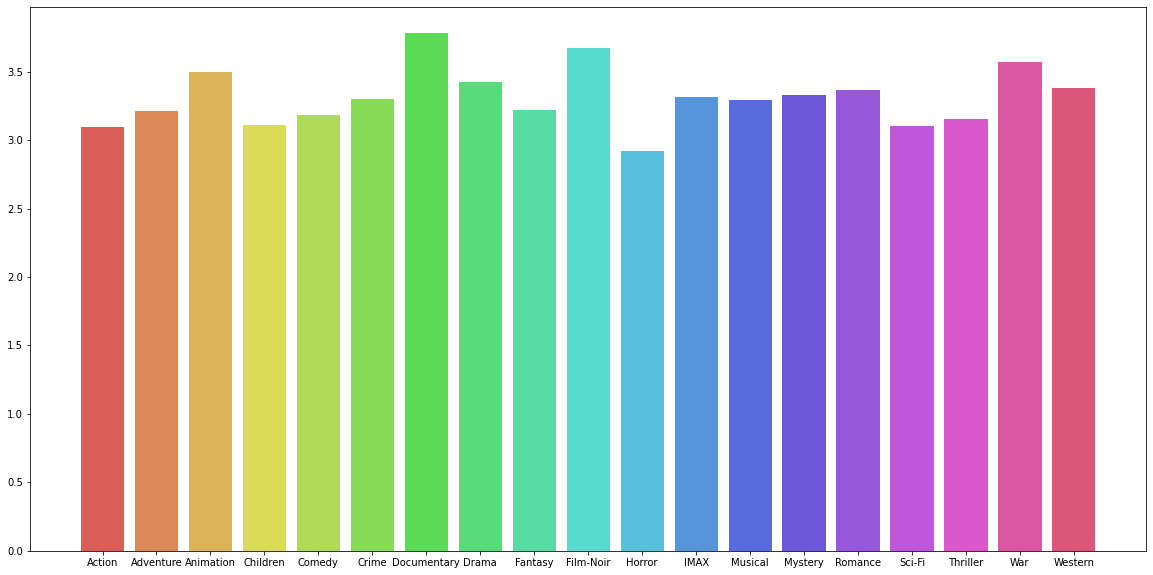

In [57]:
fig = plt.figure(figsize=(20,10))
colors = sns.color_palette('hls',len(genres))
plt.bar(genres, rating_per_genres,color=colors)

In [58]:
print(f"most popular movie: {genres[np.argmax(rating_per_genres)]}")
print(f"most unpopular movie: {genres[np.argmin(rating_per_genres)]}")

most popular movie: Documentary
most unpopular movie: Horror


#### 가장 평점이 높은 장르는 Documentary 입니다. 
생각해보면 다큐멘터리라는 장르는 허구를 전혀 사용하지 않거나 거의 사용하지 않고 어떤 사건이나 인물에 관한 사실을 보여주는 장르이기 때문에 크게 호불호가 없어 평점이 높은 것 같습니다.
#### 가장 평점이 낮은 장르는 Horror 입니다. 
호로라는 장르는 크게 호불호가 나뉘는 장르입니다. 따라서 평점이 상대적으로 낮은 것 같습니다.

### 2. 사람들이 가장 많이 보는 장르

In [59]:
view_per_genres = np.zeros((len(genres)))

In [60]:
for idx in movies.index:
    index_list = np.where(gernes_dummies.loc[idx].values)
    view_per_genres[index_list] += 1

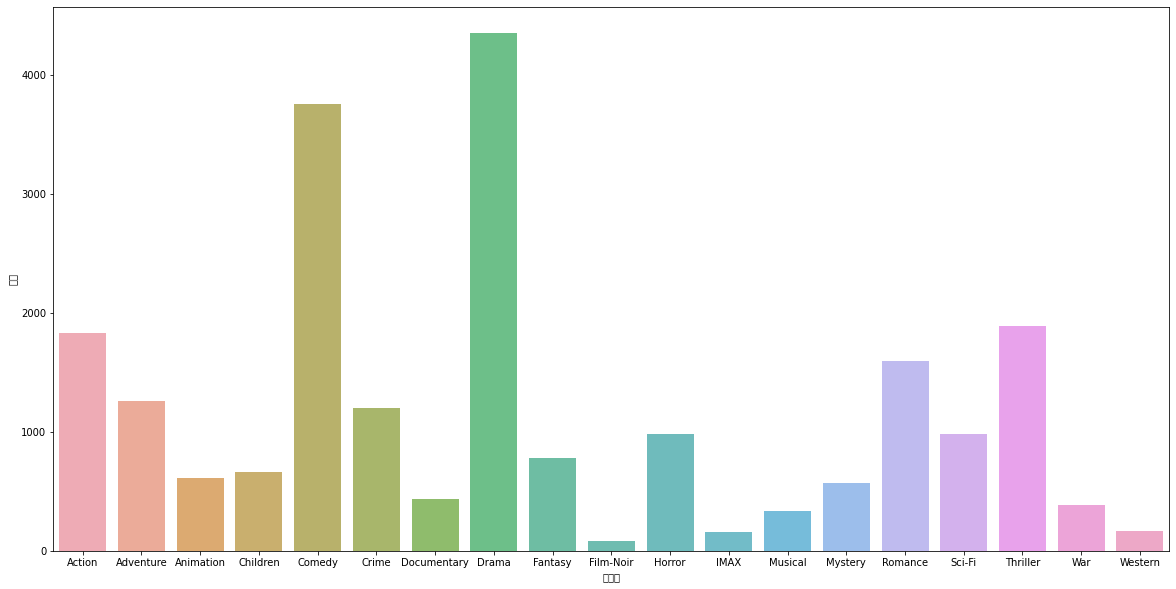

In [61]:
fig = plt.figure(figsize=(20,10))
sns.barplot(genres, view_per_genres, alpha=0.8)
plt.xlabel("영화수")
plt.ylabel("장르")
plt.show()

In [62]:
print(f"most popular genre: {genres[np.argmax(view_per_genres)]}")
print(f"most unpopular genre: {genres[np.argmin(view_per_genres)]}")

most popular genre: Drama
most unpopular genre: Film-Noir


#### 가장 많이 보는 장르는 Drama 입니다. 
드라마는 대부분의 사람들이 흔히 접하는 크게 호불호가 없는 장르이기 때문에 많이 보는 것 같습니다.
#### 가장 평점이 낮은 장르는 Film-Noir 입니다. 
누아르는 범죄와 폭력을 다루는 장르이기 때문에, 사람들이 많이 보지 않는 것 같습니다.

### 3 많이 보는 장르와 평점이 높은 장르 사이의 상관관계도

In [63]:
rating_view_genres = pd.DataFrame({'genres': genres,
                                   'view_per_genre': view_per_genres,
                                   'rating_per_genre': rating_per_genres})

,view_per_genre,rating_per_genre
view_per_genre,1.000000,-0.244825
rating_per_genre,-0.244825,1.000000


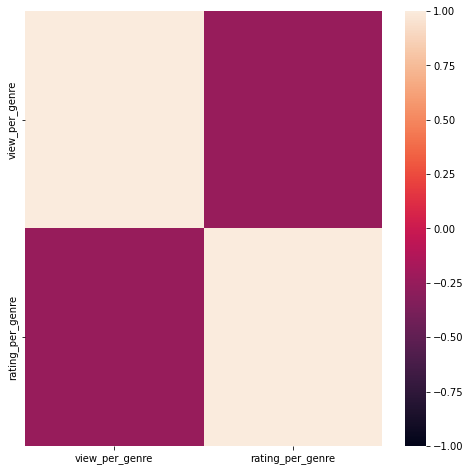

In [64]:
plt.figure(figsize=(8, 8))
sns.heatmap(rating_view_genres.corr(), vmax=1.0, vmin=-1.0)
rating_view_genres.corr()

#### 많이 보는 장르라고 평점이 높은 것은 아니다. 

### 4. 사람들이 가장 많이 보는 영화

In [65]:
movieId = movies.index.values
view_per_movies = np.zeros((len(movieId)))

In [66]:
# 평점을 매겼다면 영화를 봤다고 간주
for idx, Id in enumerate(movieId):
    view_per_movies[idx] = len(ratings[ratings.movieId==Id])

In [67]:
# 관람수 Top-10 movies
Id_list = movieId[np.argsort(-view_per_movies)[:10]]

In [68]:
for Id in Id_list:
    print(movies[movies.index == Id].title)

movieId
356    Forrest Gump (1994)
Name: title, dtype: object
movieId
318    Shawshank Redemption, The (1994)
Name: title, dtype: object
movieId
296    Pulp Fiction (1994)
Name: title, dtype: object
movieId
593    Silence of the Lambs, The (1991)
Name: title, dtype: object
movieId
2571    Matrix, The (1999)
Name: title, dtype: object
movieId
260    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object
movieId
480    Jurassic Park (1993)
Name: title, dtype: object
movieId
110    Braveheart (1995)
Name: title, dtype: object
movieId
589    Terminator 2: Judgment Day (1991)
Name: title, dtype: object
movieId
527    Schindler's List (1993)
Name: title, dtype: object


#### 관람수 top10 영화들의 title을 보면, 한번쯤 어디서 들어 본 영화들인 것을 알 수 있습니다. 가장 많이 본 영화는 Forrest Gump입니다. 

### 5. 연도별 영화의 수

In [69]:
year = movies['title'].apply(lambda x : x.rstrip()[-5:-2]+'0')
movies['year'] = year

In [70]:
movieId = movies.index.values
for idx, year in enumerate(movies.year):
    if not year.isdigit():
        movies = movies.drop(movieId[idx])

In [71]:
movie_year = movies['year'].value_counts().sort_index()
movie_year

1900       3
1910       7
1920      37
1930     134
1940     194
1950     276
1960     398
1970     497
1980    1174
1990    2204
2000    2848
2010    1914
Name: year, dtype: int64

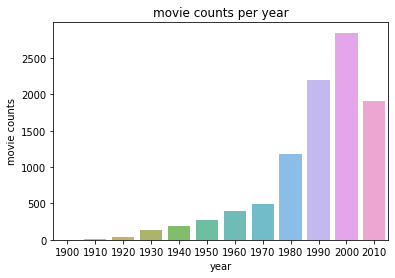

In [72]:
sns.barplot(movie_year.index, movie_year.values, alpha=0.8)
plt.title("movie counts per year")
plt.xlabel("year")
plt.ylabel("movie counts")
plt.show()

#### 가장 많이 영화가 나온 연대는 2000년도 입니다. 

### train data 생성

In [73]:
ratings_dummies = np.zeros((len(ratings.userId.unique()), len(ratings.movieId.unique())))
movieId_lists = movies.index.values
for idx, row in ratings.iterrows():
    movie_idx = np.where(movieId_lists == row.movieId)
    ratings_dummies[int(row.userId)-1][movie_idx] += row.rating

In [74]:
# shape = userId x movieId
print(ratings_dummies.shape)
print(ratings_dummies)

(610, 9690)
[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [75]:
train_data = pd.DataFrame(ratings_dummies)
train_data['avg'] = train_data.sum(axis=1)/(train_data > 0).sum(axis=1)

In [76]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,9681,9682,9683,9684,9685,9686,9687,9688,9689,avg
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.366379
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.948276
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.435897
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.555556
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.657399
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.786096
607,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134176
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.270270


## Memory-based CF

#### CF Algorithm with Mean (KNNwithMeans)

In [367]:
def substract_avg(arr, avg):
    rows, cols = arr.shape
    for i in range(rows):
        for j in range(cols):            
            if arr[i][j]:
                arr[i][j] -= avg[i][0]          
            
    return arr

def PCC_Similarity(u1, u2, eps=1e-5):
    
    u1_avg = u1[:,-1].reshape(-1,1)
    u1 = u1[:,:-1]
    
    u2_avg = u2[:,-1].reshape(-1,1)
    u2 = u2[:,:-1]
    
    u1 = substract_avg(u1, u1_avg)
    u2 = substract_avg(u2, u2_avg)
    
    
    u1_norm = LA.norm(u1, axis=1)
    u2_norm = LA.norm(u2, axis=1)
    norm = (u1_norm * u2_norm).reshape(-1,1) + eps
    return np.dot(u1, u2.T)/norm, u1, u1_avg

def RMSE(pred, data):
    RMSE = 0
    for idx in range(pred.shape[0]):
        nonzero_idx = data[idx].nonzero()[0]
        RMSE += np.sqrt(np.sum((pred[idx][nonzero_idx]-data[idx][nonzero_idx])**2/len(nonzero_idx)))

    RMSE /= pred.shape[0]
    return RMSE
    

### 1. User-based CF

In [368]:
def User_Based_CF(data, k, eps = 1e-6):
    data = data.values
    user_matrix, sub_avg_data, avg = PCC_Similarity(data.copy() ,data.copy())
    pred = np.zeros((sub_avg_data.shape))
    for idx, user_sim in enumerate(user_matrix):
        neighbors = np.argsort(-user_sim)[1:k+1]
        total_neighbor_sim = user_matrix[idx][neighbors].sum() + eps
        for neighbor in neighbors:
            pred[idx] += (sub_avg_data[neighbor] * user_matrix[idx][neighbor])/total_neighbor_sim
        pred[idx] += avg[idx]
        
    print(f"=======RMSE: {RMSE(pred, data[:,:-1])}========")    
    
User_Based_CF(train_data,3)

=======RMSE: 0.8513616311440592========


### 최적의 k 찾기

In [380]:
for k in range(1,16):
    print(f"K: {k}")
    User_Based_CF(train_data,k)

K: 1
=======RMSE: 0.9996916526763842========
K: 2
=======RMSE: 0.8929139150829436========
K: 3
=======RMSE: 0.8513616311440592========
K: 4
=======RMSE: 0.8319414341745097========
K: 5
=======RMSE: 0.8213339074407507========
K: 6
=======RMSE: 0.8144123884623068========
K: 7
=======RMSE: 0.8100504659438593========
K: 8
=======RMSE: 0.8070831210503917========
K: 9
=======RMSE: 0.8043694852449599========
K: 10
=======RMSE: 0.8027212920237471========
K: 11
=======RMSE: 0.802396762869602========
K: 12
=======RMSE: 0.8018060646120191========
K: 13
=======RMSE: 0.8012652833171868========
K: 14
=======RMSE: 0.800940694408688========
K: 15
=======RMSE: 0.8007391679939148========


#### K가 8 이상부터는 크게 값이 바뀌지 않기 때문에 최적의 K를 8이라고 설정합니다. 

### 2. Item-based CF

In [381]:
def Item_Based_CF(data, k, eps = 1e-6):
    data = data.values.T
    item_matrix, sub_avg_data, avg = PCC_Similarity(data.copy() ,data.copy())
    pred = np.zeros((sub_avg_data.shape))
    for idx, item_sim in enumerate(item_matrix):
        neighbors = np.argsort(-item_sim)[1:k+1]
        total_neighbor_sim = item_matrix[idx][neighbors].sum() + eps
        for neighbor in neighbors:
            pred[idx] += (sub_avg_data[neighbor] * item_matrix[idx][neighbor])/total_neighbor_sim
        pred[idx] += avg[idx]
        
    print(f"=======RMSE: {RMSE(pred, data[:,:-1])}========")  
    
Item_Based_CF(train_data, 20)
    

=======RMSE: 1.3753075843658435========


In [382]:
for k in range(1,16):
    print(f"K: {k}")
    Item_Based_CF(train_data,k)

K: 1
=======RMSE: 1.5942125606898707========
K: 2
=======RMSE: 1.512261914821083========
K: 3
=======RMSE: 1.4719063646116604========
K: 4
=======RMSE: 1.4498940631331594========
K: 5
=======RMSE: 1.4360076507756585========
K: 6
=======RMSE: 1.4261468968526299========
K: 7
=======RMSE: 1.416122458263541========
K: 8
=======RMSE: 1.4088163396641231========
K: 9
=======RMSE: 1.402932370198949========
K: 10
=======RMSE: 1.398069055541732========
K: 11
=======RMSE: 1.3941559240279493========
K: 12
=======RMSE: 1.3909844089317827========
K: 13
=======RMSE: 1.3884552475708107========
K: 14
=======RMSE: 1.3859071059438948========
K: 15
=======RMSE: 1.3837549492870518========


#### K가 15일때 가장 에러가 낮기 때문에 최적의 K는 15라고 생각합니다. 

    User based CF가 Item based CF보다 낮은 에러를 보여줍니다.

## Model-based CF

### 1. MF

***SVD*** : $A=U\Sigma V^T$
<br>
***MF*** : $\hat{r_{ui}}=p_uq_i^T$

shape of P = (users, k)
<br>
shape of Q = (items, k)
<br>
<br>
$Loss = \min_{P,Q}\Sigma (r_{ui} - \hat{r_{ui}})^2 + \lambda (p_u^2 + q_i^2)$
<br>
<br>
$e_{ui} = r_{ui} - \hat{r_{ui}}$
<br>
<br>
$\frac{\sigma L}{\sigma p_u} = -2(e_{ui}q_i-\lambda p_u)$
<br>
<br>
$\frac{\sigma L}{\sigma q_i} = -2(e_{ui}p_u-\lambda q_i)$

In [426]:
class MF:
    def __init__(self, users, items, k, Lambda, learning_rate):
        var = 1/np.sqrt(k) # Xavier Initialization
        self.P = np.random.normal(0, var, (users, k))
        self.Q = np.random.normal(0, var, (items, k))
        self.Lambda = Lambda
        self.k = k
        self.lr = learning_rate
        
    def l2_norm(self, vector):
        return np.sum(np.sqrt(vector**2))
    
    def train(self, data):
        users, items = data.shape
        
        # ALS
        for u in range(users):
            self.P[u] = np.linalg.inv(self.Q.T@self.Q + self.Lambda * np.eye(N=self.k))@self.Q.T@data[u]
            
        for i in range(items):
            self.Q[i] = np.linalg.inv(self.P.T@self.P + self.Lambda * np.eye(N=self.k))@self.P.T@data[:,i]
            
        #SGD
#         np.sum(e**2) + self.Lambda*(np.sum(self.P**2) + np.sum(self.Q**2))
#         for i in range(items):
#                 e = data[u][i] - pred[u][i]
#                 loss = e + self.Lambda*(self.l2_norm(self.P[u]) + self.l2_norm(self.Q[i]))
#                 print(loss)
#                 # Loss를 p, q에 대해 미분한 값
#                 diff_p = e*self.Q[i] - self.Lambda*self.P[u]
#                 diff_q = e*self.P[u] - self.Lambda*self.Q[i]

#                 # parameter update
#                 self.P[u] = self.P[u] + self.lr*diff_p
#                 self.Q[i] = self.Q[i] + self.lr*diff_q
                
        pred = self.P@self.Q.T
        return RMSE(data, pred)

In [427]:
# parameter
k = 15
Lambda = 0.001
learning_rate = 0.01
epochs = 10

In [429]:
data = train_data.values[:,:-1]
model = MF(data.shape[0], data.shape[1], k, Lambda, learning_rate)
for epoch in range(epochs):
    print(f"=======Epoch: {epoch + 1}=======")
    print(f"RMSE: {model.train(data)}")

=======Epoch: 1=======
RMSE: 0.36923215978387974
=======Epoch: 2=======
RMSE: 0.33593022802308886
=======Epoch: 3=======
RMSE: 0.33212390517885065
=======Epoch: 4=======
RMSE: 0.3310950000038299
=======Epoch: 5=======
RMSE: 0.3306347108811451
=======Epoch: 6=======
RMSE: 0.3303683433948885
=======Epoch: 7=======
RMSE: 0.3302038265994491
=======Epoch: 8=======
RMSE: 0.330101589049358
=======Epoch: 9=======
RMSE: 0.33003791303707736
=======Epoch: 10=======
RMSE: 0.32999786499035105


***처음에는 SGD 방식으로 파라미터를 업데이트하려고 시도했지만, 속도가 매우 느렸습니다. 그래서 ALS방식으로 파라미터 업데이트 하는 식으로 바꿔주었고 그 결과 매우 잘 동작하였습니다.***

## Result
#### 3개의 결과중 RMSE가 낮은 순서는 MF -> Uesr-based CF -> Item-based CF 순서입니다. 